In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import os, os.path
import cv2

# Prepare Dataset

In [2]:
# show images in a row
def showImagesHorizontally(list_of_files):
    fig = figure(figsize=(11,8))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = list_of_files[i]
        imshow(image,cmap='Greys_r')
        axis('off')

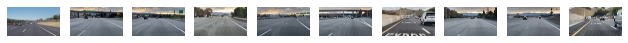

In [3]:
# show all pictures (./test_images)
all_imgs = []
path = "test_images/"
valid_images = [".jpg",".gif",".png",".tga"]
for file_name in os.listdir(path):
    if file_name != ".DS_Store":
        one_image = mpimg.imread('test_images/'+file_name)
        all_imgs.append(one_image)

showImagesHorizontally(all_imgs)

# Step 1. Color Selection
- An image contains three colors (R, G, B): Blue (0, 0, 255); Red(255, 0, 0); Green(0, 255, 0).
- We want to use color selection to find traffic line that, in the most of time, are usually white (255, 255, 255). 

In [4]:
def colorSelection(image):
    heigth = image.shape[0]
    width = image.shape[1]
#     print("the shape of the image is: ", image.shape)
    
    # make a copy of this image
    output_img = np.copy(image)
    
    # set the threshold for three colors
    th_red = 170
    th_gre = 170
    th_blu = 170

    th_rgb = [th_gre, th_gre, th_blu]
    # threshold is a boolen matrix. if one of pixal is true, it will be reset to black
    thresholds = (image[:,:,0] < th_rgb[0]) | (image[:,:,1] < th_rgb[1]) | (image[:,:,2] < th_rgb[2])    
    
    output_img[thresholds] = [0,0,0]
    return output_img

In [5]:
def showResult(arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = colorSelection(image)
        imgs_list = [image, output]
        showImagesHorizontally(imgs_list)

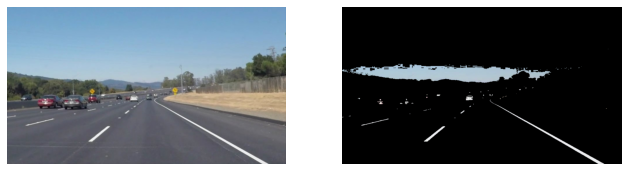

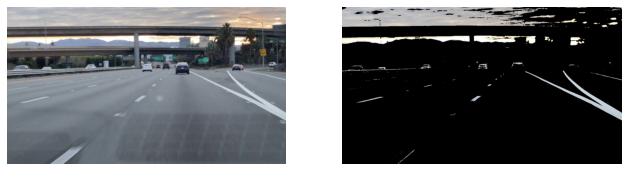

In [6]:
showResult([0, 5], all_imgs)

# Step 2: Area Attention

Since a camera that take the images/videos is mounted in a fixed position on the front of the car, we can assume that the traffic line appears in the 3/4 region of the image.

In [7]:
def colorSelectionAttention(image, attention_line):
    height = image.shape[0]
    width = image.shape[1]
    
    # make a copy of this image
    output_img = np.copy(image)
    
    # set the threshold for three colors
    th_red = 170
    th_gre = 170
    th_blu = 170

    th_rgb = [th_gre, th_gre, th_blu]   
    thresholds = (image[:,:,0] < th_rgb[0]) | (image[:,:,1] < th_rgb[1]) | (image[:,:,2] < th_rgb[2])    
    
    # set the area of attention
    blank = np.ones((attention_line, width), dtype=bool)
    attention = np.zeros((height-attention_line, width), dtype=bool)
    mask =np.append(blank, attention,  axis=0)
    
    output_img[thresholds] = [0,0,0]
    output_img[mask] = [0,0,0]
    return output_img

In [8]:
def showResult2(attention_line, arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = colorSelectionAttention(image, attention_line)
        output_without_attention = colorSelection(image)
        
        # 1. draw attention area
        plt.imshow(image)
        rect = patches.Rectangle((1, attention_line), 1279, 476, linewidth=4, edgecolor='r',linestyle='--', facecolor='none')
        plt.gca().add_patch(rect)
        axis('off')
        plt.title("Area Of Attention")
        plt.show() 
        
        
        imgs_list = [output_without_attention, output]
        showImagesHorizontally(imgs_list)

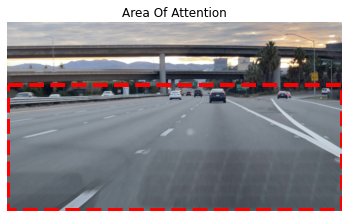

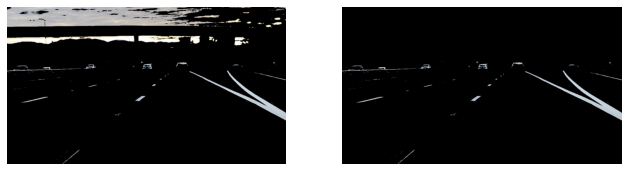

In [9]:
showResult2(240, [5], all_imgs)

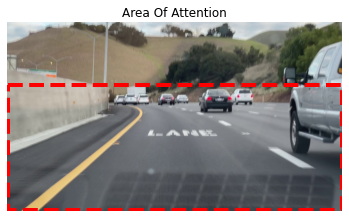

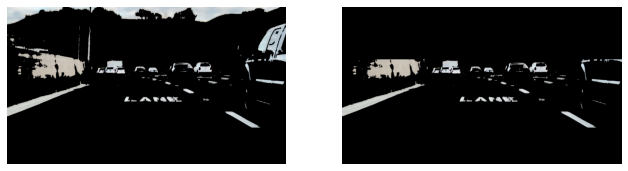

In [10]:
showResult2(240, [9], all_imgs)

# Step 3: Canny Edge Detection

In [11]:
def cannyEdgeDetection(image):
    # convert an rgb image to grayscle image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 180
    high_threshold = 100
    edges_image = cv2.Canny(blur_gray, low_threshold, high_threshold)
    return edges_image

In [12]:
def showResult3(arr_num, all_imgs):
    for i in arr_num:
        image = all_imgs[i]
        output = cannyEdgeDetection(image)
        imgs_list = [image, output]
        showImagesHorizontally(imgs_list)

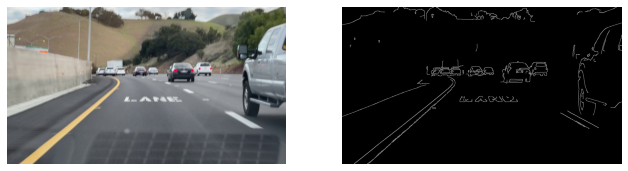

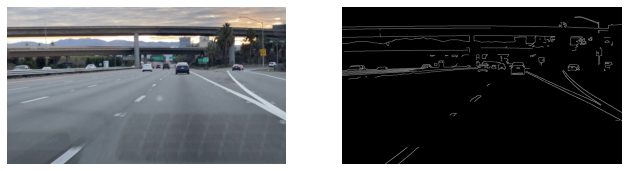

In [13]:
showResult3([9, 5], all_imgs)

# Step 4: Hough Transform

In [14]:
def houghTransform(image):
    # convert an rgb image to grayscle image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 #Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 180
    high_threshold = 100
    edges_image = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges_image) 
    ignore_mask_color = 255   

    # creating a attention mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(1, 260), (1279, 260), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges_image, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 2     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 4 #minimum number of pixels making up a line
    max_line_gap = 5    # maximum gap in pixels between connectable line segments
    
    # generating a new black screen that allow to draw traffic lines and attention area.
    line_image = np.copy(image)*0 
    

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    
    # Draw traffic lines on the mask image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),7)

    # three layer color_edges, color edge is the Canny image
    color_edges = np.dstack((edges_image, edges_image, edges_image)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.9, line_image, 1, 0)
    
    # Draw the attention area on the image   
    lines_edges = cv2.polylines(lines_edges, vertices, True, (0,0,255), 10)
    
    
    plt.imshow(image)
    plt.title("Input Image")
    plt.show()
    
    plt.imshow(lines_edges)
    plt.title("Red Traffic Line and Blue Attention Area")
    plt.show()
    
    plt.imshow(line_image)
    plt.title("Red Traffic Line")
    plt.show()

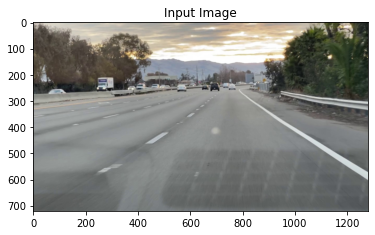

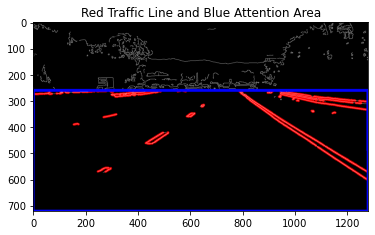

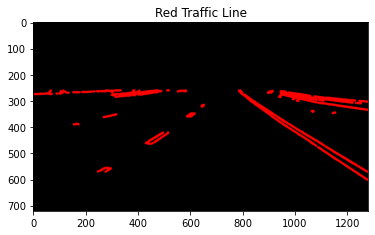

In [15]:
houghTransform(all_imgs[3])

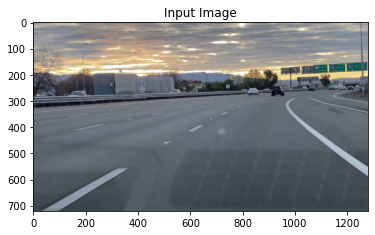

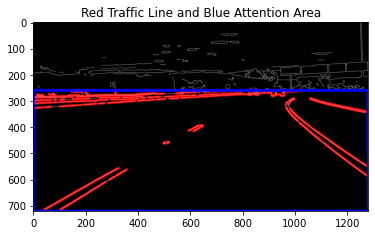

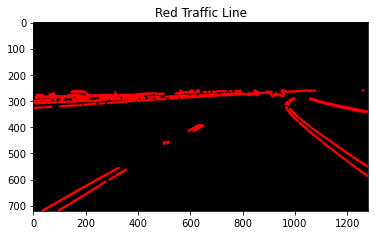

In [16]:
houghTransform(all_imgs[4])